<a href="https://colab.research.google.com/github/IHMilon/vision-model-comparison/blob/main/2.%20EfficientNet_IntelImage/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Intel Image Recognition using EfficientNet**
---
In this project, I implement and train custom **EfficientNet** on the **Intel Image Classification** dataset for scene recognition.

- **Dataset:** Intel Image Classification (25,000+ images, 6 classes, varying resolutions)  
- **Model:** EfficientNet (state-of-the-art, scalable CNN architecture)  
- **Goal:** Achieve high classification accuracy while maintaining computational efficiency

## **Dataset Gathering**
The dataset for this project was obtained from [Kaggle](https://www.kaggle.com/datasets/puneet6060/intel-image-classification), a popular platform for open datasets.

In [1]:
# Creates hidden folder named .kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
# Download the Dataset
!kaggle datasets download puneet6060/intel-image-classification 1>/dev/null

In [3]:
# Unzip the dataset
!unzip /content/intel-image-classification.zip -d dataset/ 1>/dev/null

## **Package Installation**

In [4]:
!pip install torchprofile 1>/dev/null

## **Import Required libraries**

In [5]:
import os
import math
import time
import random
import numpy as np
import warnings
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
from torchprofile import profile_macs
from sklearn.metrics import confusion_matrix
from tqdm.auto import tqdm

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.amp import autocast, GradScaler
from torch.optim.lr_scheduler import OneCycleLR

## **Reproducibility Setting**

In [6]:
seed = 10
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)

## **Device Setup**

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is:", device)

Device is: cuda


## **Clean & Inspect the Dataset**
I first ensure that all images are correct and no sample is broken

In [18]:
# Train and Test path
train_path = "/content/dataset/seg_train/seg_train"
test_path = "/content/dataset/seg_test/seg_test"

In [19]:
# Check and Clean the Dataset
def inspect(path):
    total_samples = 0
    removed_samples = 0
    # Walks through the paths and return 3 things
    for root,_,files in os.walk(path):
        # Iterate over the files and verify each one individually
        for file in files:
            file_path = os.path.join(root,file)
            try:
                image = Image.open(file_path)
                total_samples += 1
                image.verify()
            except Exception as e:
                # Removes path if sample is corrupted
                os.remove(file_path)
                removed_samples += 1
    return total_samples, removed_samples
# For training samples
train_total, train_removed = inspect(train_path)
# For testing samples
test_total, test_removed = inspect(test_path)

print(f"Total train samples: {train_total}, and removed: {train_removed}")
print(f"Total test samples: {test_total}, and removed: {test_removed}")

Total train samples: 14034, and removed: 0
Total test samples: 3000, and removed: 0


The dataset has total 14k training samples and 3k testing samples, which are few to get better result. We need to apply strong augmentation to increase the size. Another 7k are in pred folder.

In [20]:
# Samples per class
per_class_img = {}
# Iterate over all class
for cls in os.listdir(train_path):
    path = os.path.join(train_path,cls)
    # Check the class has files or not
    if os.path.isdir(path):
        # store all files into a list and calculate the length
        count = len([file for file in os.listdir(path) if file.lower().endswith(('.jpg','.png','.jpeg'))])
        per_class_img[cls] = count

print(f"The Dataset contains six classes. Where,")
# Print each class and their #samples from the dictionary
for cls, count in per_class_img.items():
    print(f"--> {cls}: {count}")

The Dataset contains six classes. Where,
--> mountain: 2512
--> glacier: 2404
--> forest: 2271
--> sea: 2274
--> buildings: 2191
--> street: 2382


In [21]:
# Get all sample's unique shape
shapes = []
# Walks through the path and return 3 lists
for root,_,files in os.walk(train_path):
    # Loops through all files and checks their shapes
    for file in files:
        path = os.path.join(root,file)
        image = Image.open(path)
        shapes.append((image.size[1], image.size[0], len(image.getbands()))) # (H,W,C)
    # keep only unique shapes
    unique_shapes = set(shapes)
print(f"The Dataset's shape is:\n {unique_shapes}")

The Dataset's shape is:
 {(143, 150, 3), (131, 150, 3), (144, 150, 3), (103, 150, 3), (81, 150, 3), (150, 150, 3), (113, 150, 3), (140, 150, 3), (124, 150, 3), (102, 150, 3), (100, 150, 3), (136, 150, 3), (134, 150, 3), (149, 150, 3), (76, 150, 3), (115, 150, 3), (110, 150, 3), (108, 150, 3), (135, 150, 3), (145, 150, 3), (133, 150, 3), (123, 150, 3), (111, 150, 3), (146, 150, 3), (105, 150, 3), (147, 150, 3), (141, 150, 3), (119, 150, 3), (97, 150, 3), (142, 150, 3), (120, 150, 3)}


We can see above that the Dataset has inconsistent image shapes. We need to deal with that.

## **Data Transformation**
I apply some transformation to improve the generalization and increase the data on training set. But the test set is only converted to Tensor. And sample's are kept to (128×128).

In [22]:
# makes all the samples in consistent sizes
train_transforms = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.RandomCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.ToTensor(),
])
# Converted to consistent sizes and tensor
test_transforms = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),
])

## **Custom Dataset Class**
To efficiently load every single image from the folder and apply transformation on each sample, I created this **Dataset Class** from pytorch `Dataset` module.

In [23]:
class Dataset(Dataset):
    def __init__(self, root_dir, transforms = None):
        self.root = root_dir
        self.transforms = transforms
        self.img_paths = []
        self.labels = []

        # Get all class name and sort those
        self.class_name = sorted(os.listdir(self.root))
        # Convert class name to label index
        self.class2idx = {name:idx for idx, name in enumerate(self.class_name)}

        # Collect all samples and corresponding labels
        for cls in self.class_name:
            class_folder = os.path.join(self.root, cls)
            # Iterate over each class's files and store them and their labels
            for file in os.listdir(class_folder):
                path = os.path.join(class_folder, file)
                self.img_paths.append(path)
                self.labels.append(self.class2idx[cls])

    def __len__(self):
        # get the length of data
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]

        # convert to RGB
        image = Image.open(img_path).convert('RGB') # for safety
        label = self.labels[idx]
        if self.transforms:
            image = self.transforms(image) #apply transformation
        return image, label

## **DataLoader**
Helps to load data in batches for both training and testing.

In [24]:
# Training set
train_dataset = Dataset(train_path, transforms = train_transforms)
train_loader = DataLoader(train_dataset, batch_size = 128, shuffle = True, pin_memory = True)

# Testing set
test_dataset = Dataset(test_path, transforms = test_transforms)
test_loader = DataLoader(test_dataset, batch_size = 64, shuffle = False, pin_memory = True)

## **Visualize the Taraing samples**
Helps to ensure that samples are loading properly and transformations are applied correctly.

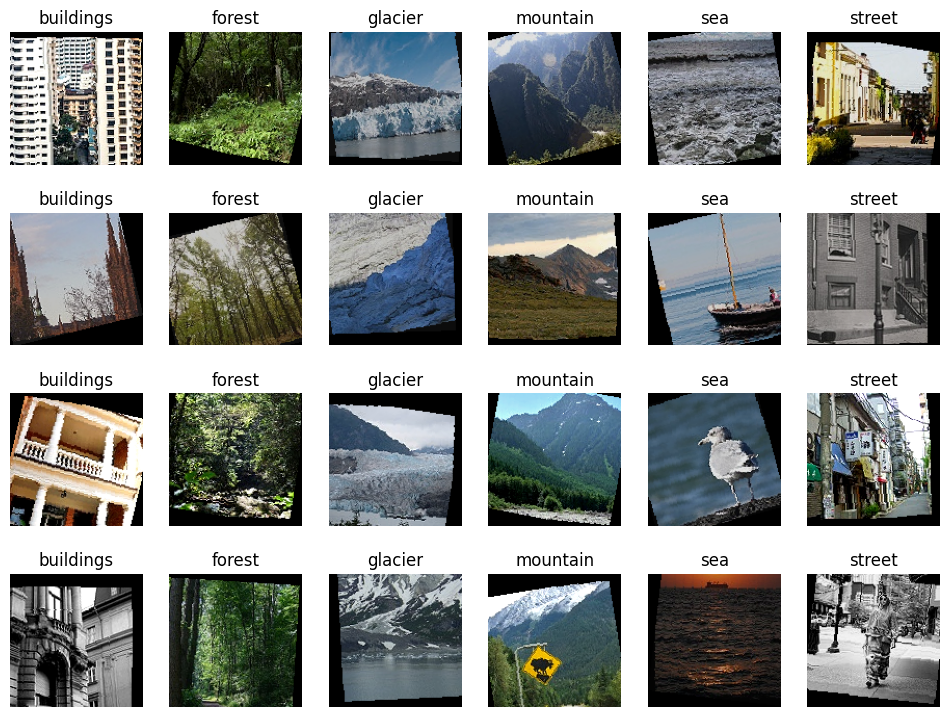

In [25]:
# Get 4 image for each class
samples = [ [] for _ in range (6)]
for image, label in train_dataset:
    if len(samples[label]) < 5:
        samples[label].append(image)

# Visualize samples from batch
plt.figure(figsize = (12,9))
for idx in range(24):
    label = idx % 6
    img = samples[label][idx // 6]

    # Convert (C,H,W) ot (H,W,C)
    img = img.permute(1,2,0)
    # Get class name
    label = train_dataset.class_name[label]
    # Plot the samples
    plt.subplot(4, 6, idx+1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')
plt.show()

## **Inspect Batch size and samples shape**
To ensure training run smoothly, we need to confirm that batches are loading properly and samples shapes are consistent.

In [26]:
# loop over the batch
for images, labels in train_loader:
    print(f"Batch images info: {images.shape}")
    print(f"Batch labels info: {labels.shape}")
    break

Batch images info: torch.Size([128, 3, 128, 128])
Batch labels info: torch.Size([128])


Batches are loading properly and there is no problem with Dataset loading.

## **Defining the EfficientNet Model**
I implemented the EfficientNet architecture from scratch. The model is composed of stacked **MBConv blocks**, each integrating `Expansion → Depthwise Convolution → Squeeze and Excitation → Projection`, making the network both efficient and scalable.

Also `Stochastic depth` applied to randomly drops (zeros out) a residual connection, which improves the generalization.

In [27]:
# Stochastic Depth
class DropBlock(nn.Module):
    def __init__(self, drop_prob):
        super().__init__()
        self.drop_prob = drop_prob

    def forward(self, x):
        # Stops it during inference and testing
        if self.drop_prob == 0.0 or not self.training:
            return x
        keep_prob = 1 - self.drop_prob
        # Creating a random tensor from 0-1
        random_tensor = keep_prob + torch.rand(x.shape[0],1,1,1, device=x.device)  # [batch, 1, 1, 1]
        # Produce binary tensor where only 0 and 1 vales are present
        binary_tensor = torch.floor(random_tensor)
        # Multiply that with each sample to make them 0 for a layer
        return (x/keep_prob) * binary_tensor

# Squeeze & Excitation Block
# creates a single values for each channels to indicates its importance
class SEBlock(nn.Module):
    def __init__(self, in_channel, reduction = 4):
        super().__init__()
        hidden_chan = in_channel // reduction
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
             nn.Conv2d(in_channel, hidden_chan, kernel_size = 1),
             nn.SiLU(inplace = True),
             nn.Conv2d(hidden_chan, in_channel, kernel_size = 1),
             nn.Sigmoid()
             )
    def forward(self, x):
        out = self.avgpool(x)
        out = self.fc(out)
        return out*x

# MBConv Block
# same as MobileNetV2's Inverted Residual Block but SE block is used additionally
class MBConv(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride, expansion, reduction = 4, drop_prob = 0.0):
        super().__init__()

        self.in_channel = in_channel
        self.out_channel = out_channel
        self.stride = stride
        self.kernel = kernel_size
        self.expansion = expansion
        self.reduction = reduction

        self.residual = (self.in_channel == self.out_channel and self.stride == 1)
        self.exp_channels = int(in_channel*expansion)


        if self.expansion > 1:
            # Expansion layer
            self.expan = nn.Sequential(
                 nn.Conv2d(self.in_channel, self.exp_channels, kernel_size = 1, stride = 1, bias = False),
                 nn.BatchNorm2d(self.exp_channels),
                 nn.SiLU(inplace=True)
                 )

        # Depthwise convolution
        self.depthwise_conv = nn.Sequential(
             nn.Conv2d(self.exp_channels, self.exp_channels, kernel_size = self.kernel, padding = kernel_size//2, groups = self.exp_channels, stride = self.stride, bias = False),
             nn.BatchNorm2d(self.exp_channels),
             nn.SiLU(inplace = True)
             )

        # Squeeze & Excitation
        self.se = SEBlock(self.exp_channels, self.reduction)

        # Linear Projection
        self.projection = nn.Sequential(
             nn.Conv2d(self.exp_channels, self.out_channel, kernel_size = 1, stride = 1, bias = False),
             nn.BatchNorm2d(self.out_channel)
             )
        self.drop_block = DropBlock(drop_prob)

    def forward(self, x):
         skip = x
         if self.expansion > 1:
             x = self.expan(x)
         x = self.depthwise_conv(x)
         x = self.se(x)
         x = self.projection(x)
         if self.residual:
             x = self.drop_block(x)
             x += skip
         return x

### **Full EfficientNet Model**

I slightly reduced the **expansion factor** from `6` to `5`, as the original configuration made the model heavier in terms of both parameters and MACs, leading to **overfitting**.  
With the reduced expansion factor, the model size drops from **7M → 3.5M parameters** and **450M → 269M MACs**, while maintaining strong performance on the **Intel Image Classification dataset**.  
This configuration offers an **optimal balance between efficiency and accuracy** for this task.

In [28]:
# Full model
class EfficientNet(nn.Module):
    def __init__(self, num_classes, version, max_drop = 0.3):
        super().__init__()

        # Parameters
        phi, res, p = version
        self.width = (1.1)**phi
        self.depth = (1.2)**phi

        # Base b0 model configuration
        base = [
            # expansion, channel, repeat, stride, kernel
            (1, 16, 1, 1, 3),
            (5, 24, 2, 2, 3),
            (5, 40, 2, 2, 5),
            (5, 80, 3, 2, 3),
            (5, 112, 2, 1, 5),
            (5, 192, 2, 2, 5),
            (5, 320, 1, 1, 3),
             ]

        # STEM layer
        out_channel = int(32*self.width) # Width Scaling
        self.stem = nn.Sequential(
             nn.Conv2d(3, out_channel, kernel_size = 3, stride = 1, padding = 1, bias = False),
             nn.BatchNorm2d(out_channel),
             nn.SiLU(inplace = True)
             )
        in_channel = out_channel


        # All MBConv Blocks
        layers = []
        total_blocks = sum([math.ceil(cfg[2] * self.depth) for cfg in base])
        block = 0
        for expansion, channel, repeat, stride, kernel in base:
            # Channel Scaling
            out_channel = int(channel*self.width)
            # Depth Scaling
            repeat = int(math.ceil(repeat*self.depth))
            # Repeats the blocks
            for i in range(repeat):
                stride = stride if i == 0 else 1
                # Gradually increases the drop_rate
                drop_rate = max_drop * (block / (total_blocks - 1))
                layers.append(MBConv(in_channel, out_channel, kernel_size = kernel, stride = stride, expansion = expansion, drop_prob = drop_rate))
                in_channel = out_channel
                block += 1

        self.blocks = nn.Sequential(*layers)

        # Head layer
        last_chan = int(1280*self.width)
        self.head = nn.Sequential(
             nn.Conv2d(in_channel, last_chan, kernel_size = 1, bias = False),
             nn.BatchNorm2d(last_chan),
             nn.SiLU(inplace=True)
             )
        # Average pool to (1×1)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.dropout = nn.Dropout(p)
        # Sends to the linear layer for classification
        self.classifier = nn.Linear(last_chan, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.blocks(x)
        x = self.head(x)
        x = self.avgpool(x).view(x.shape[0], -1)
        x = self.dropout(x)
        x = self.classifier(x)
        return x

# For all models
def efficientnet(version, num_classes = 6):
    # All 8 models with their configuration
    settings = {
        "b0": (0, 224, 0.2),
        "b1": (0.5, 240, 0.2),
        "b2": (1, 260, 0.3),
        "b3": (2, 300, 0.3),
        "b4": (3, 380, 0.4),
        "b5": (4, 456, 0.4),
        "b6": (5, 528, 0.5),
        "b7": (6, 600, 0.5),
    }
    # extracts values for the dictionary
    phi, res, drop = settings[version]
    return EfficientNet(num_classes = num_classes, version = (phi, res, drop), max_drop = drop)

In [29]:
model = efficientnet('b0', num_classes=6).to(device)

## **Model Size**
Total number of trainable parameters indicates the size of the model.

In [31]:
num_params = 0
# Iterate over the all trainable parameters and count them
for param in model.parameters():
    if param.requires_grad:
        num_params += param.numel()
print(f"Total trainable parameters: {(num_params/10**6):.2f} Million")

Total trainable parameters: 3.49 Million


## **Computation Cost**
The computational cost of a model can be estimated by the number of operations required to produce an output. One common metric is **Multiply–Accumulate Operations (MACs)**, which provides a measure of the total computations performed during inference.

In [32]:
# To clear unwanted massages
warnings.filterwarnings("ignore")

# Creates a dummy tensor
x = torch.ones(1, 3, 112, 112).to(device)
# Calculate the macs
macs = profile_macs(model, x)
print(f"Computation Cost: {(macs/10**6):.2f} Million MACs")

Computation Cost: 269.85 Million MACs


## **Training Setup**
The training process is configured with `CrossEntropyLoss` as the objective function, the `AdamW` optimizer with weight decay for regularization, and the `OneCycleLR` scheduler for dynamic learning rate adjustment. To improve efficiency, training is performed with `mixed precision`, which accelerates computations and reduces GPU memory consumption—aligning with best practices in modern deep learning workflows.

In [37]:
# Number of training epochs
Epochs = 50

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimization Algorithm
optimizer = optim.AdamW(model.parameters(), lr = 0.001, weight_decay = 5e-4)

# Learning rate Scheduler
scheduler = OneCycleLR(
            optimizer,
            max_lr = 0.1,
            steps_per_epoch = len(train_loader),
            epochs = Epochs
            )

# Initialize gradient scaler to scale the loss
scaler = GradScaler('cuda')

## **Training Function for one Epoch**

In [35]:
def train(model, train_loader, criterion, optimizer, scheduler, scaler, device):

    # Set to training mode
    model.train()
    train_loss, num_correct, num_samples = 0, 0, 0
    num_batches = 0
    # Iterate over batches
    for images, labels in train_loader:
        # Move to GPU
        images, labels = images.to(device), labels.to(device)

        # Zero out the gradiants
        optimizer.zero_grad()

        # Forward pass with Mixed Precision
        with autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Scale the loss and update weights
        scaler.scale(loss).backward()
        scaler.step(optimizer)

        # Update the Scaler
        scaler.update()

        # update the lr
        scheduler.step()

        # Convert logits to class index
        preds = outputs.argmax(dim = 1)

        # update the training matrices
        num_batches += 1
        train_loss += loss.item()
        num_samples += labels.size(0)
        num_correct += (preds == labels).sum().item()

    # Get the loss and accuracy
    train_loss = train_loss/num_batches
    train_acc = (num_correct/num_samples)*100

    return train_loss, train_acc

## **Evaluation Function for one Epoch**

In [36]:
def evaluate(model, test_loader, criterion, device):

    # Set to evaluation mode
    model.eval()
    test_loss, test_samples, test_correct = 0, 0, 0
    num_batches = 0

    # Stops calculating the gradiants
    with torch.inference_mode():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Convert to class index
            preds = outputs.argmax(dim = 1)

            # update test matrices
            num_batches += 1
            test_loss += loss.item()
            test_samples += labels.size(0)
            test_correct += (preds == labels).sum().item()

    # Get the loss and accuracy
    test_loss = test_loss/num_batches
    test_acc = (test_correct/test_samples)*100

    return test_loss, test_acc

## **Training Loop**
The model is trained over multiple epochs, iteratively updating weights using the optimizer while tracking training and validation metrics (loss and accuracy) to monitor learning progress.

In [38]:
# Store the acc & loss for each epoch
train_losses, train_accs = [], []
test_losses, test_accs =[], []

# Waits for GPU to finish all works
torch.cuda.synchronize()
# Start time
start_time = time.time()

# Train the model
for epoch in range(1, Epochs+1):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, scheduler, scaler, device)
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    # Store metrics for visualization
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    test_losses.append(test_loss)
    test_accs.append(test_acc)

    # Prints every after 5 epochs for fewer logs
    if epoch % 5 == 0:
        print(f"{epoch}. Train Accuracy {train_acc:.2f}%, Test Accuracy {test_acc:.2f}%")
        print("-"*50)

# Waits for GPU to finish training
torch.cuda.synchronize()
# Calculate the Training Time
end_time = time.time()
total_time = end_time - start_time
print(f"\nTotal time to train the model is {(total_time/60):.2f} Minutes")

5. Train Accuracy 71.27%, Test Accuracy 46.57%
--------------------------------------------------
10. Train Accuracy 73.24%, Test Accuracy 44.53%
--------------------------------------------------
15. Train Accuracy 76.44%, Test Accuracy 61.93%
--------------------------------------------------
20. Train Accuracy 80.23%, Test Accuracy 70.67%
--------------------------------------------------
25. Train Accuracy 81.05%, Test Accuracy 58.67%
--------------------------------------------------
30. Train Accuracy 83.84%, Test Accuracy 78.10%
--------------------------------------------------
35. Train Accuracy 86.18%, Test Accuracy 82.70%
--------------------------------------------------
40. Train Accuracy 88.01%, Test Accuracy 81.13%
--------------------------------------------------
45. Train Accuracy 89.13%, Test Accuracy 86.50%
--------------------------------------------------
50. Train Accuracy 90.15%, Test Accuracy 86.87%
--------------------------------------------------

Total time

## **Loss & Accuracy Plot**
Analyze the model’s performance by comparing training and validation accuracy, as well as their respective loss curves, to assess learning behavior and potential overfitting.

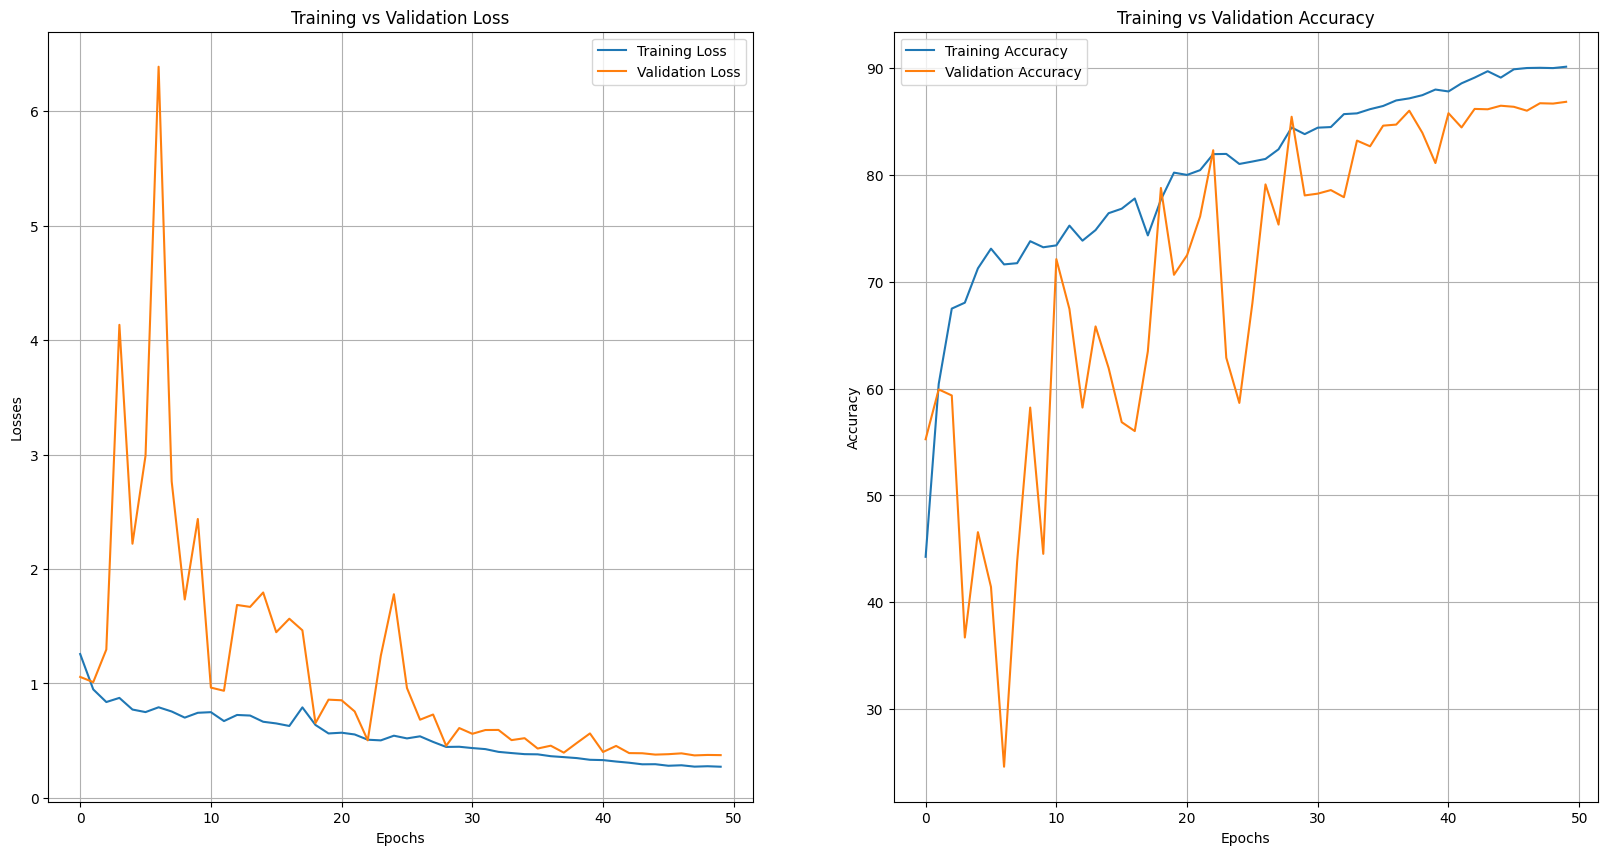

In [39]:
plt.figure(figsize=(20,10))

# Plot the Train and Val Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label = "Training Loss")
plt.plot(test_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

# Plot the Train and Val Accuracy
plt.subplot(1,2,2)
plt.plot(train_accs, label = "Training Accuracy")
plt.plot(test_accs, label = "Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

## **Prediction Visualization**
I visualize the model’s predictions on the test set to qualitatively assess its performance across different classes.

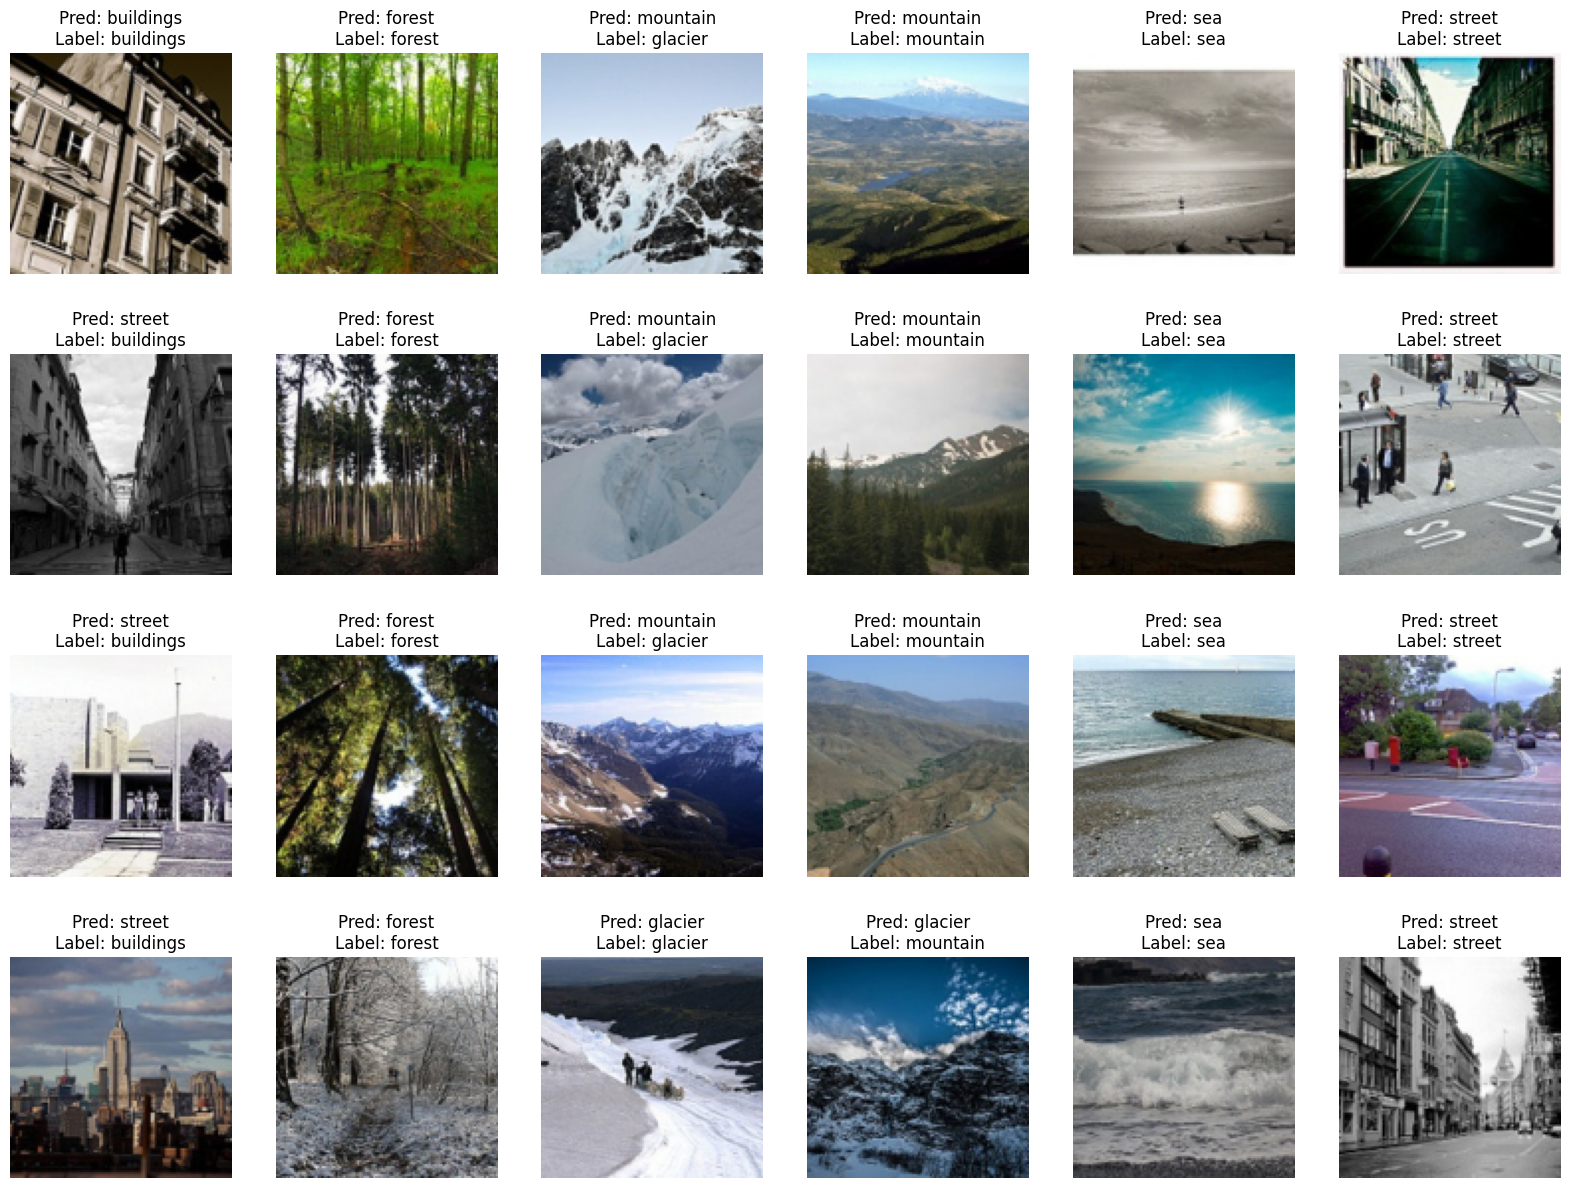

In [46]:
# Collect 4 samples from each class
samples = [[] for _ in range(6)]
# Iterate through the validation dataset
for image, label in test_dataset:
    if len(samples[label]) < 4:
        samples[label].append(image)

# Prediction and visualization
plt.figure(figsize=(20,15))
for idx in range(24):
    label_idx = idx % 6
    image = samples[label_idx][idx//6]

    # Predict the class
    model.eval()
    with torch.inference_mode():
         pred = model(image.unsqueeze(dim=0).to(device))
         pred = pred.argmax(dim = 1).item()

    # Covert shape CHW to HWC for Vis.
    image = image.permute(1,2,0)
    # Convert label idx to name
    true_label = test_dataset.class_name[label_idx]
    pred_label = test_dataset.class_name[pred]

    # Create subplot for vis.
    plt.subplot(4, 6, 1+idx)
    plt.imshow(image)
    plt.title(f"Pred: {pred_label}"+ "\n" + f"Label: {true_label}")
    plt.axis('off')
plt.show()

## **Confusion Matrix**
The confusion matrix visualizes the model’s performance on the test set, highlighting how well each class is predicted and revealing which classes are most frequently misclassified.

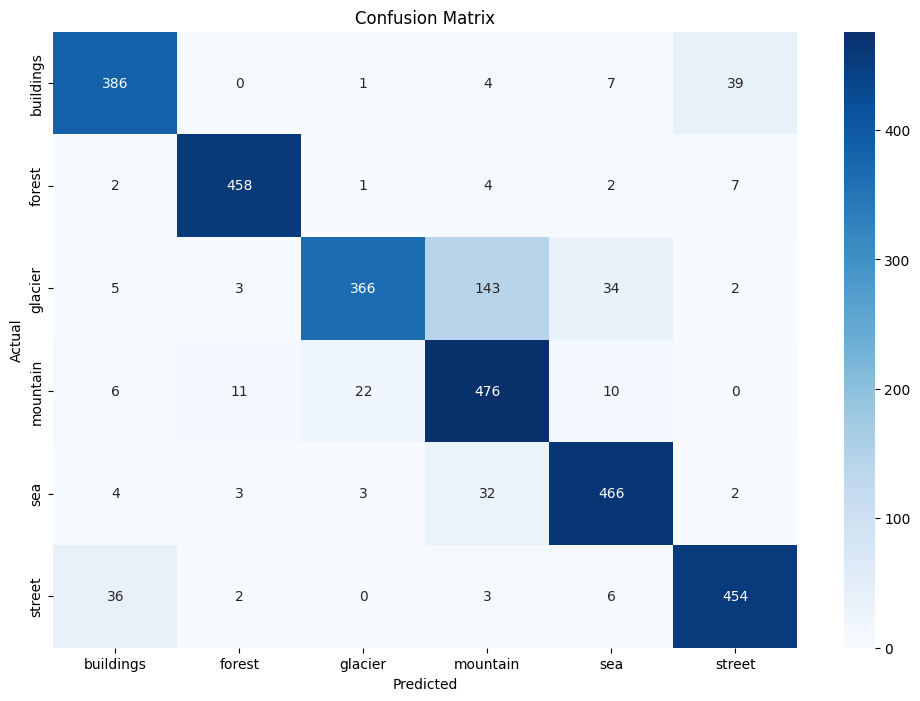

In [47]:
# Collect predictions and true labels
true_labels = []
predictions = []

model.eval()
# Stops gradients calculation
with torch.inference_mode():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        # Forward pass
        outputs = model(images)
        pred = outputs.argmax(dim=1)
        # Store all true and predicted lables
        true_labels.extend(labels.cpu().numpy())
        predictions.extend(pred.cpu().numpy())

# Compute confusion matrix
matrix = confusion_matrix(true_labels, predictions)

# Get class name from label index
class_name = test_dataset.class_name

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(matrix, annot=True, fmt='d', xticklabels=class_name, yticklabels=class_name, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

We can see that the model mostly confuses about the **glacier** and **mountain**. Then it confuses about **building** and **Street**

## **Latency and Throughput**
We can evaluate the model’s performance by measuring **inference time (latency)** and **samples processed per second (throughput)**, providing insights into its real-world efficiency.

In [50]:
# Creating fake batch of images
dummy_samples = torch.ones(128, 3, 128, 128).to(device)

model.eval()
# waits for GPU to finish previous works
torch.cuda.synchronize()
starting_time = time.time()

with torch.inference_mode():
    output= model(dummy_samples)

# Waits for GPU to finish calculation
torch.cuda.synchronize()
finish_time = time.time()

# Total time per batch
total_time = finish_time - starting_time

# Throughput
throughput = int(256/total_time)

print(f"Time Per Batch: {total_time*1000:.2f}Ms")
print(f"Throughput: {throughput:.2f} img/sec")

Time Per Batch: 162.37Ms
Throughput: 1576.00 img/sec
